In [3]:
from itertools import combinations
from qnute.hamiltonian import Hamiltonian
from qnute.helpers.lattice import get_center, manhattan_dist
import numpy as np
from math import isclose

# S:set[int] = {3}
# u_domains:list[set[int]] = [
#     {0,1}, {1,2}, {2,3}, {3,4}
# ]
# invert_map = {i:(i,0) for i in range(5)}
# S_center = get_center([invert_map[index] for index in S])
# u_domain_centers:list[np.ndarray[float]] = [get_center([invert_map[index] for index in domain]) for domain in u_domains]

# print('Support:',S)
# r = 1
# if len(S) > len(u_domains[0]):
#     r+=1
# found_flag = False
# min_dist = float('inf')
# u_index_list = []
# while r < len(u_domains) and not found_flag:
#     print(f'r={r}')
#     for u_indices in combinations(range(len(u_domains)), r):
#         u = [u_domains[i] for i in u_indices]
#         print('\nCombination:', u)
#         x = set.union(*u)
#         print('    Union:  ', x)
#         if S.issubset(x):
#             found_flag = True
#             print('    Support is a subset of the union!')
#             dist = 0.0
#             for i in u_indices:
#                 dist += manhattan_dist(S_center, u_domain_centers[i])
#             print(f'        Distance of cover from support center:    {dist}')
#             if isclose(dist,min_dist):
#                 u_index_list += list(u_indices)
#             else:
#                 if dist < min_dist:
#                     min_dist = dist
#                     u_index_list = list(u_indices)
            
#     print()
#     r += 1
# if not found_flag:
#     u_index_list = list(range(len(u_domains)))
# else:
#     r -= 1
# print(f'Number of covering domains: {r}')
# print(f'Minimum Distance: {min_dist}')
# print(f'U indices:        {u_index_list}')

In [4]:
def get_minimum_cover(support:set[int], u_domains:list[set[int]], invert_map:dict[int,tuple[int]]) -> list[int]:
    support_center = get_center([invert_map[index] for index in support])
    u_domain_centers:list[np.ndarray[float]] = [get_center([invert_map[index] for index in domain]) for domain in u_domains]

    r = 1
    if len(support) > len(u_domains[0]):
        r+=1
    found_flag = False
    min_dist = float('inf')
    u_index_list = []
    while r < len(u_domains) and not found_flag:
        for u_indices in combinations(range(len(u_domains)), r):
            u = [u_domains[i] for i in u_indices]
            x = set.union(*u)
            if support.issubset(x):
                found_flag = True
                dist = 0.0
                for i in u_indices:
                    dist += manhattan_dist(support_center, u_domain_centers[i])
                if isclose(dist,min_dist):
                    u_index_list += list(u_indices)
                else:
                    if dist < min_dist:
                        min_dist = dist
                        u_index_list = list(u_indices)
                
        # print()
        r += 1
    if not found_flag:
        u_index_list = list(range(len(u_domains)))
    else:
        r -= 1
    return u_index_list

In [5]:
def get_support(ham:Hamiltonian, term:int) -> set[int]:
    p = ham.pterm_list[ham.hm_indices[term]]['pauli_id']
    support = set()
    for i in range(ham.nbits):
        if p % 4 != 0:
            support.add(i)
        p //= 4
    return support

# get_support(ham, 2)

In [27]:
# from qnute.hamiltonian import Hamiltonian
from qnute.hamiltonian.laplacian import generateLaplaceHamiltonian1D

num_qbits = 3
ham:Hamiltonian = generateLaplaceHamiltonian1D(num_qbits)
print(ham)
u_domains = [{i,i+1} for i in range(num_qbits-1)]
invert_map = {i:(i,) for i in range(num_qbits)}

def get_amplitude_splits(ham:Hamiltonian, u_domains:list[set[int]], invert_map:dict[int,tuple[int]]):
    amplitude_splits = np.zeros((ham.num_terms,len(u_domains)),dtype=np.float64)

    for term in range(ham.num_terms):
        support = get_support(ham, term)
        
        u_index_list = get_minimum_cover(support, u_domains, invert_map)
        frac = 1.0/len(u_index_list)
        for ui in u_index_list:
            amplitude_splits[term,ui] += frac
    return amplitude_splits

amplitude_splits = get_amplitude_splits(ham, u_domains, invert_map)
print(amplitude_splits)

Hamiltonian Pauli Terms and Amplitudes:

	I_2 I_1 X_0  : (1.00000+0.00000j)

	I_2 X_1 X_0  : (0.50000+0.00000j)
	I_2 Y_1 Y_0  : (0.50000+0.00000j)

	X_2 X_1 X_0  : (0.25000+0.00000j)
	X_2 Y_1 Y_0  : (-0.25000+0.00000j)
	Y_2 X_1 Y_0  : (0.25000+0.00000j)
	Y_2 Y_1 X_0  : (0.25000+0.00000j)
	I_2 I_1 I_0  : (-2.00000+0.00000j)

[[1.  0. ]
 [1.  0. ]
 [0.5 0.5]]


In [28]:
ham.hm_list

[[array([1], dtype=uint32), array([1.+0.j]), array([0], dtype=uint32)],
 [array([ 5, 10], dtype=uint32),
  array([0.5+0.j, 0.5+0.j]),
  array([0, 1], dtype=uint32)],
 [array([21, 26, 38, 41,  0], dtype=uint32),
  array([ 0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j, -2.  +0.j]),
  array([0, 1, 2], dtype=uint32)]]

In [29]:
ham.get_hm_pterms(1)

array([( 5, 0.5+0.j), (10, 0.5+0.j)],
      dtype=[('pauli_id', '<u4'), ('amplitude', '<c16')])

In [30]:
amplitude_splits

array([[1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5]])

In [31]:
from qnute.hamiltonian import hm_dtype
def rearrange_terms(ham:Hamiltonian, u_domains:list[set[int]], amplitude_splits)->Hamiltonian:
    new_pterm_list = np.zeros(len(u_domains)*ham.pterm_list.shape[0], dtype=hm_dtype)
    new_hm_indices = []
    counter = 0
    for i,dom in enumerate(u_domains):
        new_hm_indices.append(counter)
        for term in range(ham.num_terms):
            for pterm in ham.get_hm_pterms(term):
                new_amplitude = pterm['amplitude']*amplitude_splits[term,i]
                if new_amplitude != 0.0:
                    new_pterm_list[counter]=(pterm['pauli_id'], pterm['amplitude']*amplitude_splits[term,i])
                    counter += 1

    new_pterm_list.resize(counter)

    print(new_pterm_list)
    print(new_hm_indices)
    from copy import deepcopy

    ham2 = deepcopy(ham)
    ham2.pterm_list = new_pterm_list
    ham2.hm_indices = new_hm_indices
    ham2.num_terms = len(u_domains)

    return ham2

ham2 = rearrange_terms(ham, u_domains, amplitude_splits)
print(ham2)
print(ham2.get_matrix().real)

[( 1,  1.   +0.j) ( 5,  0.5  +0.j) (10,  0.5  +0.j) (21,  0.125+0.j)
 (26, -0.125+0.j) (38,  0.125+0.j) (41,  0.125+0.j) ( 0, -1.   +0.j)
 (21,  0.125+0.j) (26, -0.125+0.j) (38,  0.125+0.j) (41,  0.125+0.j)
 ( 0, -1.   +0.j)]
[0, 8]
Hamiltonian Pauli Terms and Amplitudes:

	I_2 I_1 X_0  : (1.00000+0.00000j)
	I_2 X_1 X_0  : (0.50000+0.00000j)
	I_2 Y_1 Y_0  : (0.50000+0.00000j)
	X_2 X_1 X_0  : (0.12500+0.00000j)
	X_2 Y_1 Y_0  : (-0.12500+0.00000j)
	Y_2 X_1 Y_0  : (0.12500+0.00000j)
	Y_2 Y_1 X_0  : (0.12500+0.00000j)
	I_2 I_1 I_0  : (-1.00000+0.00000j)

	X_2 X_1 X_0  : (0.12500+0.00000j)
	X_2 Y_1 Y_0  : (-0.12500+0.00000j)
	Y_2 X_1 Y_0  : (0.12500+0.00000j)
	Y_2 Y_1 X_0  : (0.12500+0.00000j)
	I_2 I_1 I_0  : (-1.00000+0.00000j)

[[-2.  1.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0

In [48]:
import matplotlib.pyplot as plt

def plot_lattice(L, marked_points=None, title:str='Title'):
    fig, ax = plt.subplots()
    
    # Plot lattice points
    for i in range(L):
        for j in range(L):
            ax.plot(i, j, marker='o', markersize=5, color='lightgrey')
    
    # Plot marked lattice points
    if marked_points:
        for point in marked_points:
            ax.plot(point[0], point[1], marker='o', markersize=5, color='red')
    
    # Set axis limits
    ax.set_xlim(-0.5, L - 0.5)
    ax.set_ylim(-0.5, L - 0.5)
    
    # Set aspect ratio to equal
    ax.set_aspect('equal', 'box')
    ax.set_xticks(range(L))
    ax.set_yticks(range(L))
    fig.suptitle(title)
    plt.grid(True)
    plt.show()

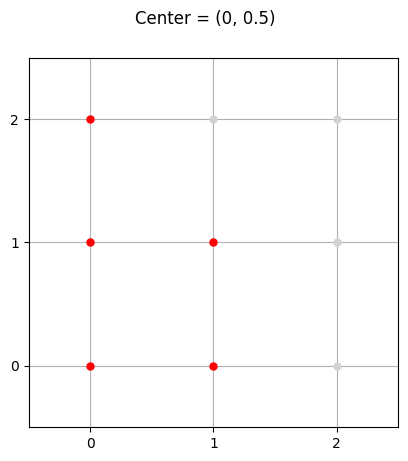

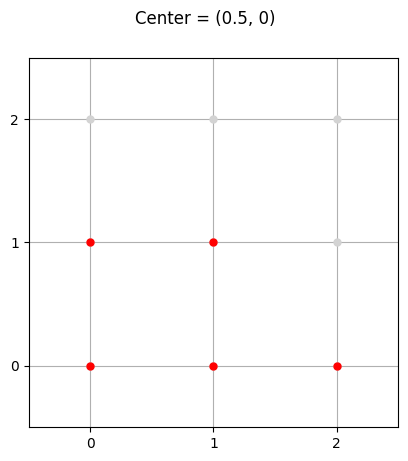

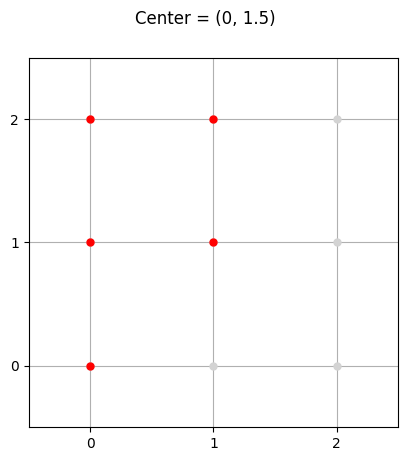

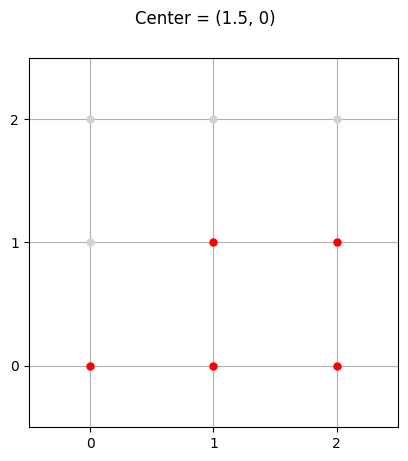

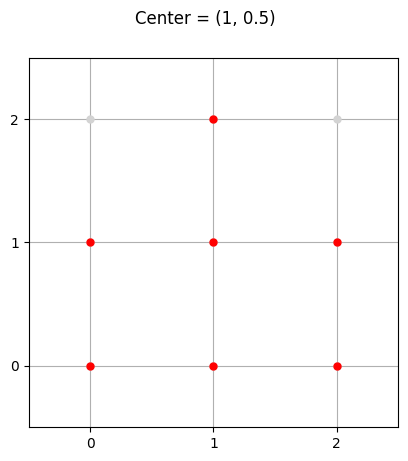

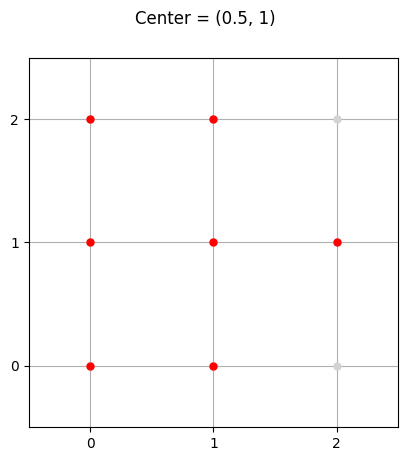

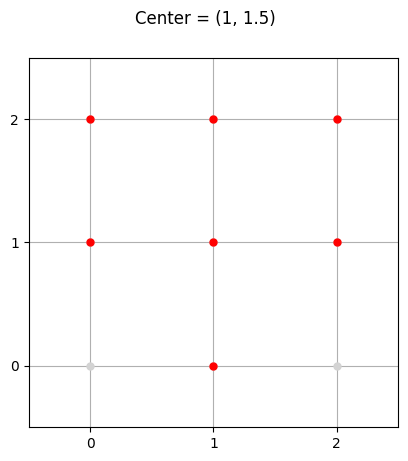

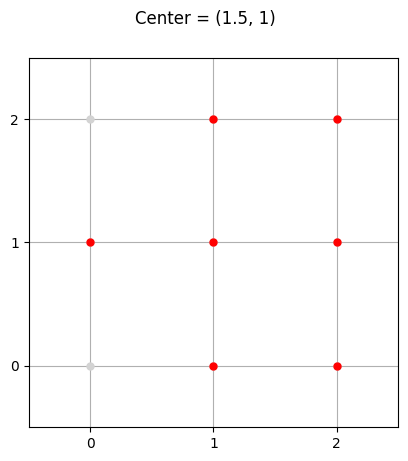

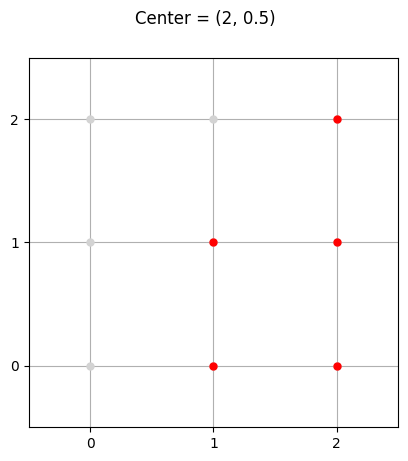

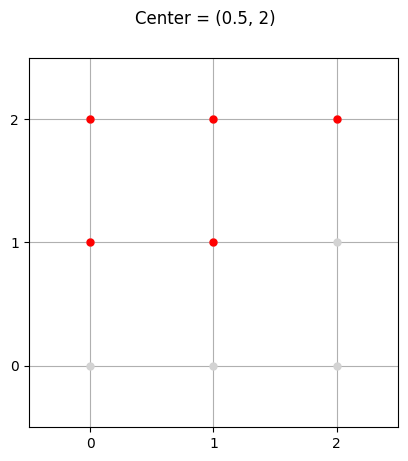

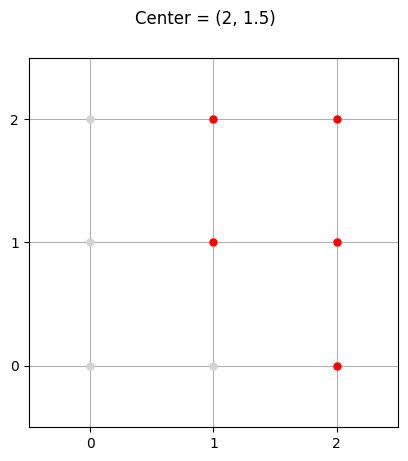

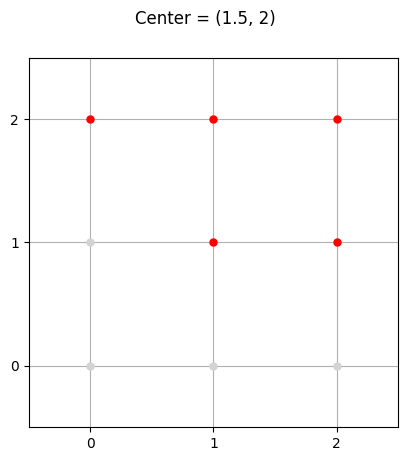

In [58]:
from qnute.helpers.lattice import get_m_sphere

d = 2
l = 3
D = 4

for i in range(l):
    for j in range(l-1):
        center = (i,j + 0.5)
        plot_lattice(l, get_m_sphere(center, D//2, d, l), f'Center = {center}')
        center = (j + 0.5,i)
        plot_lattice(l, get_m_sphere(center, D//2, d, l), f'Center = {center}')

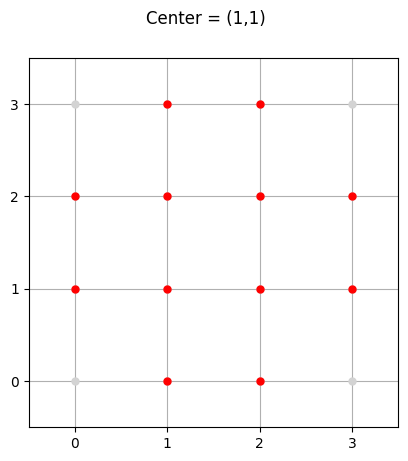

In [68]:
plot_lattice(4, get_m_sphere((1.5,1.5), 2, d, 4), f'Center = (1,1)')